In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import cv2
import math

In [ ]:
def FrameCapture(path,out):
  frames=[]
  vidObj = cv2.VideoCapture(path)
  count = 0
  success = 1
  while count<30:
    success, image = vidObj.read()
    frames.append(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))
    count += 1
  return frames

oframes=FrameCapture("/content/drive/My Drive/sflab4/original/original.avi",'original')
tframes=FrameCapture("/content/drive/MyDrive/sflab4/tampered/tampered.avi","tampered")

In [ ]:
h=[1,-3,3,-1]
t=2 
q=3

In [ ]:
def computeResidualMatrix(image):
  for row in range(0,image.shape[0]):
    for i in range(0,image.shape[1]-3):
      image[row][i] =  ( image[row][i])+ ( -3 *image[row][i+1]) + ( 3*image[row][i+2]) - ( image[row][i+3])
      image[row][i] = min(t,max(-t, math.floor(image[row][i] / q)))

  for row in range(0,image.shape[0]):
      for i in range(0,image.shape[1]):
        if image[row][i] >int(2) :
          image[row][i]=0
          
  return image


In [ ]:
def findWindows(image):
  windows=[]
  stepSize=8
  for x in range(0, image.shape[1] - 128 , stepSize):
   for y in range(0, image.shape[0] - 128, stepSize):
      window = image[x:x + 128, y:y + 128]
      windows.append(window)
  
  #print(len(windows))
  return windows


In [ ]:
from collections import Counter

def hist(im):
  dic={}
  c = Counter()
  for i in range(im.shape[1]-3):
    for j in im[:,i:i+4]:
      if tuple(j) in c:
        c[tuple(j)] += 1
      elif tuple(j)[::-1] in c:
        c[tuple(j)[::-1]] += 1
      else :
        c[tuple(j)] = 1
    
    
  
  return c.values()

In [ ]:
def make325(lis):
  listsize = len(lis)
  x= np.zeros(325-listsize).astype('int')
  return lis + list(x)


In [ ]:
def computeStatisticalDescriptor(frames):
  rhist=[]
  chist=[]
  x=[5,6,7]
  for i in x:
    print(i)
    rowResidual = frames[i].astype('int')
    rowResidual = computeResidualMatrix(rowResidual)
    rwindow = findWindows(rowResidual)
    for k in range(len(rwindow)):
      rhist.append(make325(list(hist(rwindow[k]))))
    
    colResidual = frames[i].T.astype('int')
    colResidual = computeResidualMatrix(colResidual)
    cwindow = findWindows(colResidual)
    print(len(cwindow))
    for k in range(len(cwindow)):
      chist.append(make325(list(hist(cwindow[k]))))
    
  return rhist,chist

In [ ]:
def opticalFlow(imgs):
    angle = []
    magnitude=[]
    prev = imgs[4]
    for i in range(5, 8):
        flow = cv2.calcOpticalFlowFarneback(prev, imgs[i], None,0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        angle.append(ang)
        magnitude.append(mag)
    
    return np.array(magnitude),np.array(angle)

In [ ]:
def normalize(mag,ang):
  for i in range(len(mag)):
    mag[i]=cv2.normalize(mag[i],None,0,255,cv2.NORM_MINMAX)
    ang[i] =ang[i]*360/np.pi/2
  return mag,ang

In [ ]:
def computeMagAngle(mag,ang):
  ohist=[]
  for i in range(len(mag)):
    magwindow = findWindows(mag[i])
    angwindow= findWindows(ang[i])
    binhist=[]
    for k in range(len(magwindow)):
      I1=magwindow[k]
      I2=angwindow[k]
      h=I1.shape[0]
      w=I1.shape[1]
      x=0
      y=0
      bin_array=np.zeros((4,4),dtype=int);
      for i in range(h):
        for j in range(w):
          x=int(I1[i][j]//64)
          if(x==4):
            x=3
          y=int(I2[i][j]//90)
          if(y==4):
            y=3
          bin_array[x][y]+=1
      bin_array=np.reshape(bin_array,(1,16))
      bin_array=bin_array[0]
      binhist.append(bin_array)
    ohist.append(binhist)
  return ohist

In [ ]:
def computeFinalhistogram(rhist,chist,ohist):
  rowh = []
  colh = []
  for i in range(0,len(rhist),len(rhist)//3):
    rowh.append(rhist[i:i+4480])
    colh.append(chist[i:i+4480])

  fhist=list()
  for ind in range(3):
    fhist.append(np.concatenate([np.array(rowh[ind]),np.array(colh[ind]) , np.array(ohist[ind])] ,axis=1))
  
  return fhist

In [ ]:
rhist,chist = computeStatisticalDescriptor(oframes)

5
4480
6
4480
7
4480


In [ ]:
mag,ang = opticalFlow(oframes)
mag,ang = normalize(mag,ang)
ohist = computeMagAngle(mag,ang)


In [ ]:
fhist = computeFinalhistogram(rhist,chist,ohist)

In [ ]:
import pickle
file = open('/content/drive/My Drive/sflab4/original/rhist',"wb")
pickle.dump(rhist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/chist',"wb")
pickle.dump(chist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/ohist',"wb")
pickle.dump(ohist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/fhist',"wb")
pickle.dump(fhist, file)
file.close()

In [ ]:
file = open('/content/drive/My Drive/sflab4/original/rhist',"rb")
rhist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/chist',"rb")
chist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/ohist',"rb")
ohist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/original/fhist',"rb")
fhist = pickle.load(file)
file.close()

In [ ]:
trhist,tchist = computeStatisticalDescriptor(tframes)

In [ ]:
tmag,tang = opticalFlow(tframes)
tmag,tang = normalize(tmag,tang)
tohist = computeMagAngle(tmag,tang)


In [ ]:
tfhist = computeFinalhistogram(trhist,tchist,tohist)

In [ ]:
import pickle
file = open('/content/drive/My Drive/sflab4/tampered/trhist',"wb")
pickle.dump(trhist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tchist',"wb")
pickle.dump(tchist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tohist',"wb")
pickle.dump(tohist, file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tfhist',"wb")
pickle.dump(tfhist, file)
file.close()

In [ ]:

file = open('/content/drive/My Drive/sflab4/tampered/trhist',"rb")
trhist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tchist',"rb")
tchist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tohist',"rb")
tohist = pickle.load(file)
file.close()
file = open('/content/drive/My Drive/sflab4/tampered/tfhist',"rb")
tfhist = pickle.load(file)
file.close()

In [ ]:
import pandas as pd
import scipy as sp
import numpy as np

df=pd.DataFrame(data=np.array(fhist[0]))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665
0,40,39,35,12,13,135,54,45,17,47,904,150,44,33,12,24,921,390,918,156,406,386,85,303,79,315,194,165,149,697,92,200,6,6,14,25,245,71,69,119,...,2,2,1,2,1,2,2,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4874,2949,3474,2950,129,0,0,80,272,0,0,57,1592,0,0,7
1,387,917,393,899,382,212,162,708,918,175,41,107,53,146,129,154,47,45,35,52,152,101,144,199,44,151,44,23,7,305,228,30,26,14,30,8,36,23,46,314,...,1,2,3,1,2,2,3,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4801,3186,3644,2889,76,0,0,80,201,0,0,57,1443,0,0,7
2,80,26,30,28,64,18,5,889,146,307,71,997,332,150,48,943,316,399,758,259,104,400,62,157,77,17,37,213,192,9,24,161,11,69,15,116,35,188,176,29,...,1,2,3,1,2,3,3,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4637,3547,3970,2648,54,0,0,80,161,0,0,57,1223,0,0,7
3,63,4,6,9,116,418,21,83,45,47,382,921,208,10,122,863,307,114,1068,318,29,102,179,772,149,417,271,91,146,191,26,107,79,34,51,85,41,39,194,9,...,1,2,3,1,2,3,3,5,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4657,3780,4153,2494,38,0,0,80,146,0,0,57,972,0,0,7
4,13,2,1,22,64,144,42,232,21,26,79,146,144,87,15,6,869,377,439,434,114,302,935,1124,800,203,280,331,110,160,61,111,85,318,175,205,157,33,22,10,...,1,2,3,2,2,4,3,5,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4923,3806,4175,2461,24,0,0,79,125,0,0,57,727,0,0,7


In [ ]:
df2=pd.DataFrame(data=np.array(tfhist[0]))
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665
0,27,9,55,20,1456,988,170,578,67,28,239,384,6,40,1265,315,461,286,374,55,202,328,21,54,56,119,37,25,49,13,18,46,121,32,118,5,12,224,28,16,...,2,1,2,1,2,4,5,2,1,1,2,2,1,1,0,0,0,0,0,0,0,0,0,0,3773,3369,4647,2185,2307,0,0,54,49,0,0,0,0,0,0,0
1,1475,1303,1008,51,550,471,386,244,176,341,294,305,169,142,100,56,13,81,86,26,136,20,7,67,21,34,20,13,120,29,31,6,60,22,34,368,79,170,197,215,...,6,3,3,1,5,1,2,2,1,5,1,1,1,1,0,0,0,0,0,0,0,0,0,0,3645,3880,4519,2132,2110,0,0,49,49,0,0,0,0,0,0,0
2,111,23,21,29,17,1523,1326,624,1025,307,230,472,344,311,111,394,42,122,11,9,66,136,359,89,245,48,44,77,55,158,32,31,10,23,1,23,37,39,53,21,...,7,3,3,1,6,1,3,3,2,9,1,1,1,3,1,1,0,0,0,0,0,0,0,0,3611,4278,4394,2140,1893,0,0,24,44,0,0,0,0,0,0,0
3,22,12,12,15,4,41,58,121,24,1520,1332,400,12,360,235,1025,479,634,52,75,360,135,27,22,26,10,29,25,22,15,24,21,4,7,18,4,103,111,35,33,...,7,4,3,2,6,1,3,3,2,9,1,2,1,3,1,1,0,0,0,0,0,0,0,0,3943,4451,4169,2137,1638,0,0,13,33,0,0,0,0,0,0,0
4,17,24,1037,34,10,76,1284,23,309,228,89,19,352,1592,22,628,318,132,394,365,508,48,128,6,13,22,72,13,57,68,3,71,177,16,16,9,6,172,9,32,...,7,4,3,4,6,1,3,3,2,9,1,2,1,3,1,1,1,0,0,0,0,0,0,0,4141,4630,4067,2128,1372,0,0,13,33,0,0,0,0,0,0,0


In [ ]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [ ]:
x=[]
for i in range(3):
  df=pd.DataFrame(data=np.array(fhist[i]))
  mah=mahalanobis(x=df2,data=df)
  x.append(mah)



In [ ]:
norm = np.array(x)/np.max(np.array(x))
norm=norm*255

In [ ]:
np.max(norm)

255.0

In [ ]:
norm.shape

(3, 4480)

In [ ]:
max=180
index =0
w=[]
for j in range(len(norm[1])):
  if norm[1][j] > 180  :
    w.append(j)


In [ ]:
w

[1506,
 1507,
 1561,
 1562,
 1563,
 1564,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 1676,
 1677,
 1725,
 1726,
 1727,
 1728,
 1729,
 1730,
 1731,
 1732,
 1733,
 1781,
 1782,
 1783,
 1784,
 1785,
 1786,
 1787,
 1788,
 1789,
 1837,
 1838,
 1839,
 1840,
 1841,
 1842,
 1843,
 1844,
 1845,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012]

In [ ]:
oframe6 = oframes[6]
tframe6 = tframes[6]
owindows = findWindows(oframe6)
twindows = findWindows(tframe6)

In [ ]:
from matplotlib import pyplot as plt

for i in w:
  frame = owindows[i] - twindows[i]
  xyz= np.concatenate([owindows[i] , twindows[i],frame],axis=1)
  plt.imshow(xyz,interpolation='nearest')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
frame = oframes[5]-tframes[5]

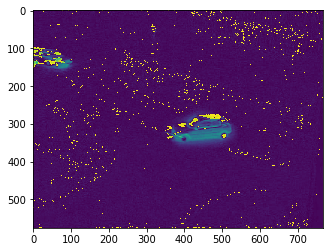

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(frame, interpolation='nearest')
plt.show()